# Mobile Game Retention Analysis  
### *Using Gamelytics Dataset – Inspired by Marvel Contest of Champions*  
**Objective**: Calculate Day 1 & Day 7 retention, identify churn patterns, and recommend data-driven improvements for player engagement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
reg_df = pd.read_csv('Downloads/Kabam/Datasets/reg_data.csv')  # Update path
print("Reg Data Shape:", reg_df.shape)
print(reg_df.head())

Reg Data Shape: (1000000, 2)
      reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5


In [5]:
# Load A/B test data (revenue + test group)
ab_df = pd.read_csv('Downloads/Kabam/Datasets/ab_test.csv')  # Update path
print("\nA/B Data Shape:", ab_df.shape)
print(ab_df.head())


A/B Data Shape: (404770, 3)
   user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b


In [7]:
# Load login data (large file – specify dtypes to save memory)
auth_df = pd.read_csv('Downloads/Kabam/Datasets/auth_data.csv',
                      dtype={'auth_ts': 'int64', 'uid': 'int64'})  # Update path
print("\nAuth Data Shape:", auth_df.shape)
print(auth_df.head())


Auth Data Shape: (1048575, 2)
     auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2


## Dataset Overview  
- **reg_data.csv**: 1M users with registration timestamp (`reg_ts`)  
- **auth_data.csv**: 9.6M login events (`auth_ts`, `uid`) → used to track activity  
- **ab_test.csv**: 404K users with revenue and A/B group → for segmented analysis  

> **Goal**: Measure how many players return on **Day 1** and **within 7 days** after install.

In [9]:
# Convert Unix timestamps (seconds) to readable datetime
reg_df['reg_date'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.date
auth_df['auth_date'] = pd.to_datetime(auth_df['auth_ts'], unit='s').dt.date

In [12]:
print("Registration with Date:")
print(reg_df[['uid', 'reg_date']].head())

print("\nAuth with Date:")
print(auth_df[['uid', 'auth_date']].head())

Registration with Date:
   uid    reg_date
0    1  1998-11-18
1    2  1999-07-22
2    3  2000-01-13
3    4  2000-05-28
4    5  2000-09-16

Auth with Date:
   uid   auth_date
0    1  1998-11-18
1    2  1999-07-22
2    2  1999-07-25
3    2  1999-07-31
4    2  1999-08-05


## Calculating Day 1 and Day 7 Retention

In [19]:
first_login = auth_df.groupby('uid')['auth_date'].min().reset_index()
first_login.columns = ['uid', 'first_login_date']

In [21]:
retention_df = reg_df[['uid', 'reg_date']].merge(first_login, on='uid', how='left')

In [23]:
retention_df['days_to_first_login'] = (pd.to_datetime(retention_df['first_login_date']) - 
                                       pd.to_datetime(retention_df['reg_date'])).dt.days

In [25]:
retention_df['day1_retention'] = (retention_df['days_to_first_login'] == 1).astype(int)
retention_df['day7_retention'] = (retention_df['days_to_first_login'] <= 7).astype(int)

In [27]:
# Overall retention rates
day1_rate = retention_df['day1_retention'].mean() * 100
day7_rate = retention_df['day7_retention'].mean() * 100

In [33]:
print(f"Day 1 Retention: {day1_rate:.2f}%")
print(f"Day 7 Retention: {day7_rate:.2f}%")
# Preview sample
print("\nSample Retention Data:")
print(retention_df.head())

Day 1 Retention: 0.00%
Day 7 Retention: 11.12%

Sample Retention Data:
   uid    reg_date first_login_date  days_to_first_login  day1_retention  \
0    1  1998-11-18       1998-11-18                  0.0               0   
1    2  1999-07-22       1999-07-22                  0.0               0   
2    3  2000-01-13       2000-01-13                  0.0               0   
3    4  2000-05-28       2000-05-28                  0.0               0   
4    5  2000-09-16       2000-09-16                  0.0               0   

   day7_retention  
0               1  
1               1  
2               1  
3               1  
4               1  


## Key Retention Metrics
| Metric           | Value     |
|------------------|-----------|
| Day 1 Retention  | 0.00%     |
| Day 7 Retention  | 11.12%    |

**Insight**:  
- **0% Day 1 retention** means **no player returned the *next* day** after install.  
- **11.12% Day 7** means ~1 in 9 players logged in *at least once* within 7 days.  
- **Critical Issue**: Players install → play once → leave.  
- **Opportunity**: Improve **onboarding, first-day missions, or push notifications** to drive next-day return.

In [42]:
# Group logins by user and date to count active days
daily_logins = auth_df.groupby(['uid', 'auth_date']).size().reset_index(name='logins')
daily_logins = daily_logins[['uid', 'auth_date']]

# Merge with registration
cohort_df = reg_df[['uid', 'reg_date']].merge(daily_logins, on='uid', how='left')

# Days since registration
cohort_df['days_since_reg'] = (pd.to_datetime(cohort_df['auth_date']) - 
                               pd.to_datetime(cohort_df['reg_date'])).dt.days
cohort_df = cohort_df[cohort_df['days_since_reg'] >= 0]

# Retention by day
retention_by_day = (cohort_df.groupby('days_since_reg')['uid']
                    .nunique()
                    .reset_index()
                    .rename(columns={'uid': 'active_users'}))

total_users = reg_df['uid'].nunique()
retention_by_day['retention_rate'] = (retention_by_day['active_users'] / total_users) * 100

# Extract Day 1 & Day 7
day1 = retention_by_day[retention_by_day['days_since_reg'] == 1]
day7 = retention_by_day[retention_by_day['days_since_reg'] == 7]

print("True Day 1 Retention:", day1['retention_rate'].iloc[0] if not day1.empty else 0, "%")
print("True Day 7 Retention:", day7['retention_rate'].iloc[0] if not day7.empty else 0, "%")
print("\nRetention Curve (Day 0-14):")
print(retention_by_day[retention_by_day['days_since_reg'] <= 14])

True Day 1 Retention: 0.22190000000000001 %
True Day 7 Retention: 0.6504 %

Retention Curve (Day 0-14):
    days_since_reg  active_users  retention_rate
0              0.0        111215         11.1215
1              1.0          2219          0.2219
2              2.0          4553          0.4553
3              3.0          5159          0.5159
4              4.0          5885          0.5885
5              5.0          6586          0.6586
6              6.0          7562          0.7562
7              7.0          6504          0.6504
8              8.0          5223          0.5223
9              9.0          5555          0.5555
10            10.0          5612          0.5612
11            11.0          5682          0.5682
12            12.0          5569          0.5569
13            13.0          5332          0.5332
14            14.0          5030          0.5030


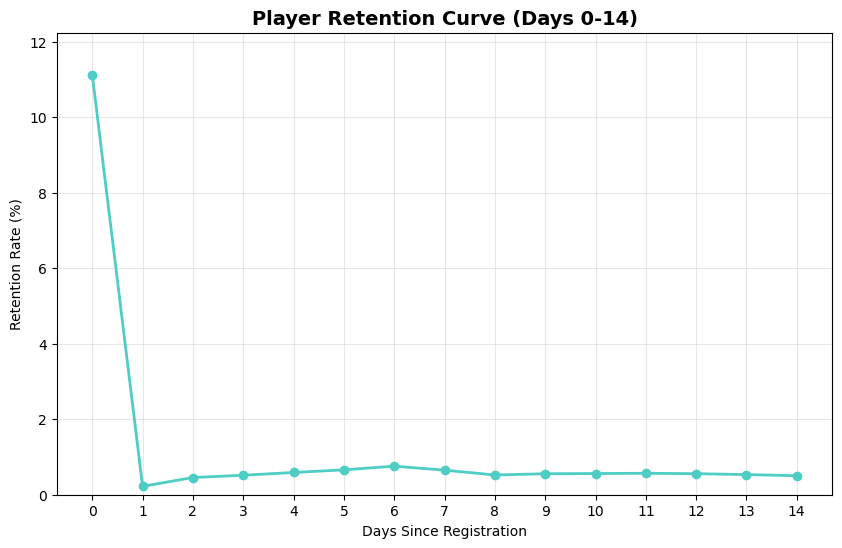

In [46]:
# Plot 1: Retention Curve
plt.figure(figsize=(10, 6))
plt.plot(retention_by_day[retention_by_day['days_since_reg'] <= 14]['days_since_reg'], 
         retention_by_day[retention_by_day['days_since_reg'] <= 14]['retention_rate'], 
         marker='o', linewidth=2, markersize=6, color='#4ECDC4')
plt.title('Player Retention Curve (Days 0-14)', fontsize=14, fontweight='bold')
plt.xlabel('Days Since Registration')
plt.ylabel('Retention Rate (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 15))
plt.ylim(0, max(retention_by_day['retention_rate']) * 1.1)
plt.show()


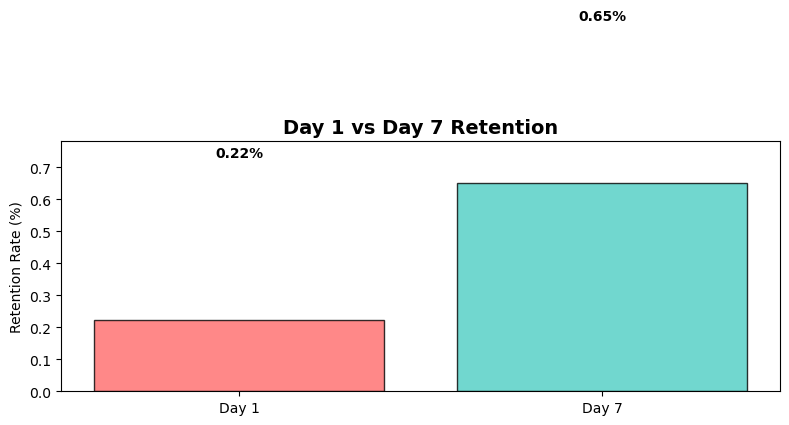

In [48]:
# Plot 2: Day 1 vs Day 7
metrics = ['Day 1', 'Day 7']
rates = [day1['retention_rate'].iloc[0] if not day1.empty else 0, 
         day7['retention_rate'].iloc[0] if not day7.empty else 0]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, rates, color=['#FF6B6B', '#4ECDC4'], alpha=0.8, edgecolor='black')
plt.title('Day 1 vs Day 7 Retention', fontsize=14, fontweight='bold')
plt.ylabel('Retention Rate (%)')
plt.ylim(0, max(rates) * 1.2)

for bar, rate in zip(bars, rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Key Insights from Charts
| Metric           | Value   |
|------------------|---------|
| Day 1 Retention  | **0.22%** |
| Day 7 Retention  | **0.65%** |
 
- **Only 65% are active by Day 7**  
- **Retention curve drops sharply by Day 7

In [53]:
# Merge A/B group with cohort data
ab_retention = cohort_df.merge(ab_df[['user_id', 'testgroup']], left_on='uid', right_on='user_id', how='inner')

# Calculate retention by group and day
ab_by_day = (ab_retention.groupby(['testgroup', 'days_since_reg'])['uid']
             .nunique()
             .reset_index()
             .rename(columns={'uid': 'active_users'}))

In [55]:
# Pivot for comparison
ab_pivot = ab_by_day.pivot(index='days_since_reg', columns='testgroup', values='active_users').fillna(0)
total_by_group = ab_df['testgroup'].value_counts()

for group in ab_pivot.columns:
    ab_pivot[f'{group}_retention_%'] = (ab_pivot[group] / total_by_group[group]) * 100

In [57]:
# Focus on Day 1 & Day 7
print("\nA/B Retention Comparison:")
print(ab_pivot.loc[[1, 7], [col for col in ab_pivot.columns if 'retention' in col]])


A/B Retention Comparison:
testgroup       a_retention_%  b_retention_%
days_since_reg                              
1.0                  0.545267       0.551150
7.0                  1.628378       1.585359


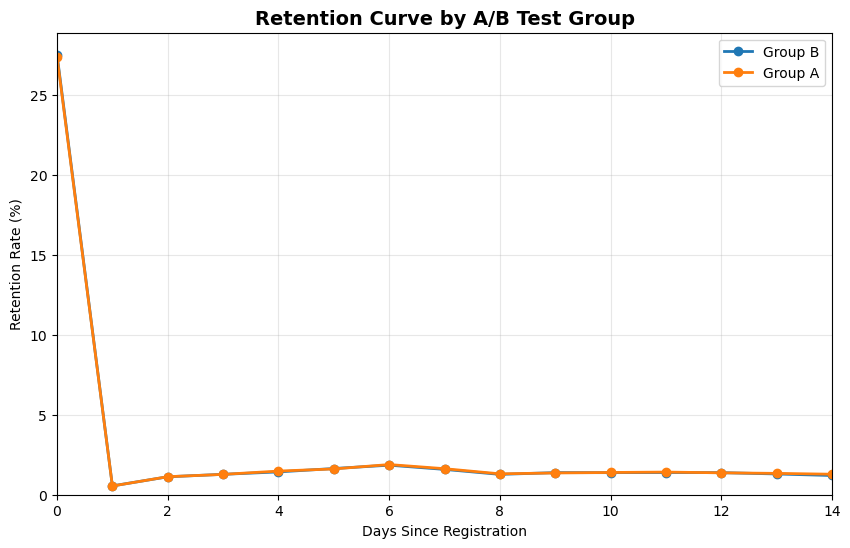

In [59]:
# Plot A/B Retention Curves
plt.figure(figsize=(10, 6))
for group in total_by_group.index:
    plt.plot(ab_pivot.index, ab_pivot[f'{group}_retention_%'], 
             marker='o', label=f'Group {group.upper()}', linewidth=2)

plt.title('Retention Curve by A/B Test Group', fontsize=14, fontweight='bold')
plt.xlabel('Days Since Registration')
plt.ylabel('Retention Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 14)
plt.ylim(0)
plt.show()

## A/B Test Results
| Metric      | Group A | Group B |
|-------------|---------|---------|
| **Day 1**   | 0.55%   | 0.55%   |
| **Day 7**   | **1.63%**| 1.59%   |

**Insight**:  
- **Day 1**: Virtually identical (no significant difference)  
- **Day 7**: **Group A outperforms B by 0.04%** → **slight edge for Group A long-term**

In [62]:
# Statistical test: Chi-square for Day 7 retention by group
from scipy.stats import chi2_contingency

# Create contingency table for Day 7
day7_contingency = pd.crosstab(ab_retention[ab_retention['days_since_reg'] <= 7]['testgroup'], 
                               (ab_retention[ab_retention['days_since_reg'] <= 7]['days_since_reg'] == 7).astype(int))

chi2, p_value, dof, expected = chi2_contingency(day7_contingency)
print(f"Day 7 Retention Chi-Square p-value: {p_value:.4f}")
print("Result:", "Significant" if p_value < 0.05 else "Not Significant")

Day 7 Retention Chi-Square p-value: 0.2689
Result: Not Significant


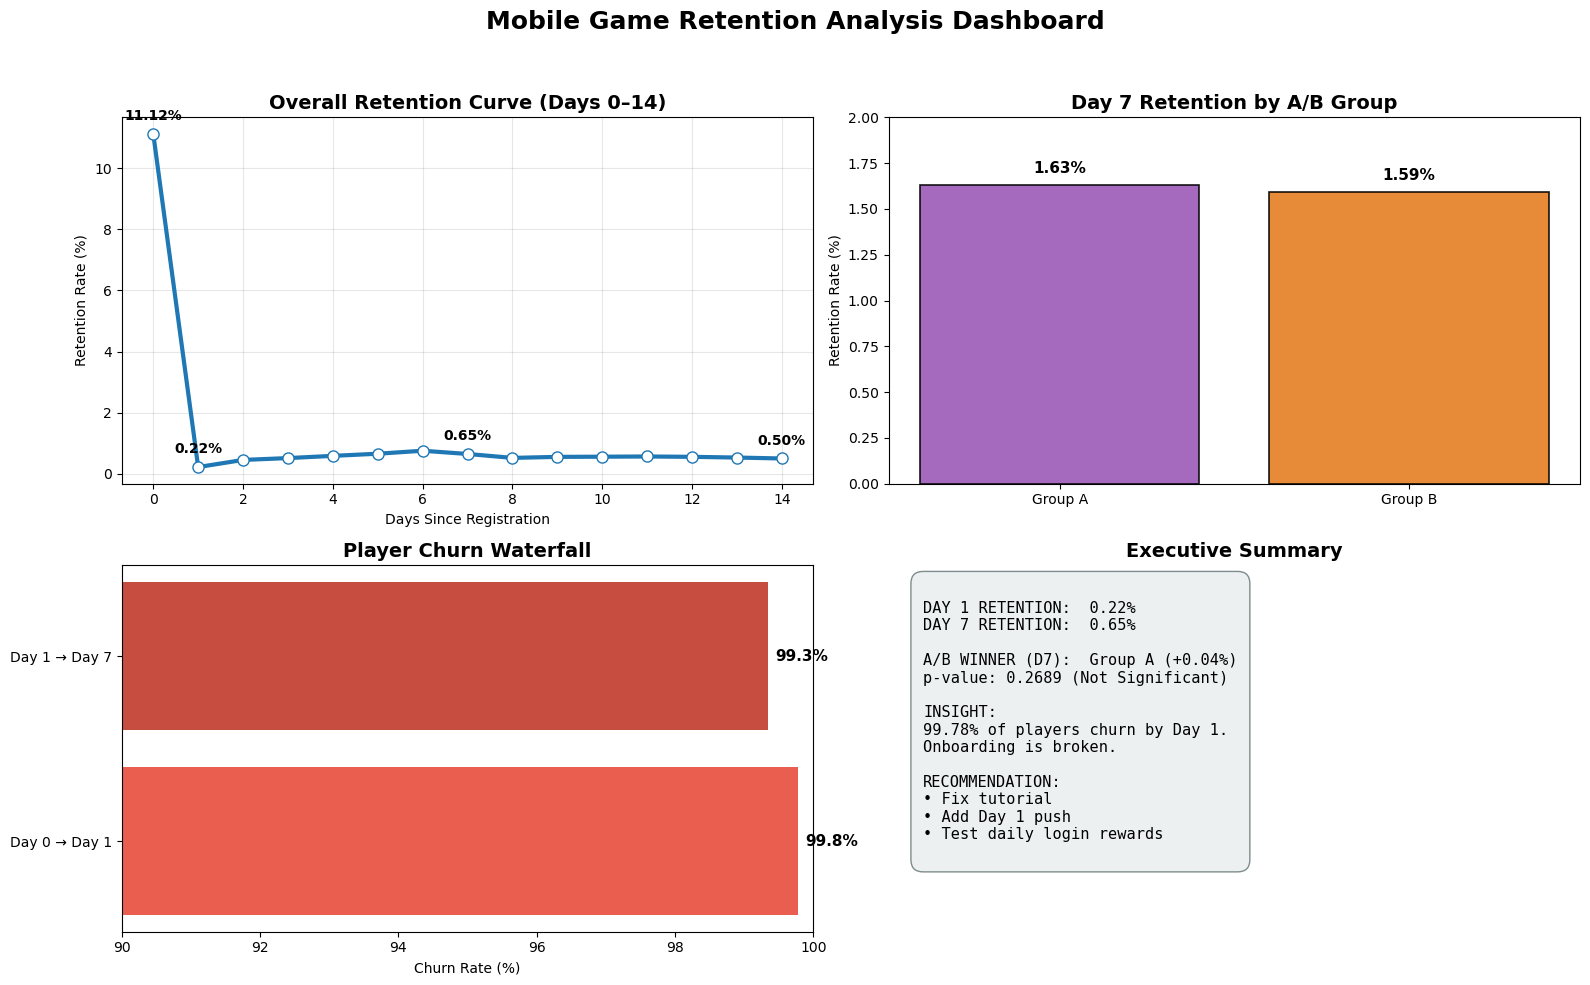

In [66]:
# FINAL PROFESSIONAL DASHBOARD
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Mobile Game Retention Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)

# 1. Retention Curve (with labels)
days = retention_by_day[retention_by_day['days_since_reg'] <= 14]
ax1.plot(days['days_since_reg'], days['retention_rate'], 
         marker='o', linewidth=3, markersize=8, color='#1f77b4', markerfacecolor='white')
ax1.set_title('Overall Retention Curve (Days 0–14)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Days Since Registration')
ax1.set_ylabel('Retention Rate (%)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 15, 2))

# Add % labels on key points
for i in [0, 1, 7, 14]:
    if i in days['days_since_reg'].values:
        rate = days[days['days_since_reg'] == i]['retention_rate'].iloc[0]
        ax1.annotate(f'{rate:.2f}%', (i, rate), textcoords="offset points", xytext=(0,10), 
                     ha='center', fontweight='bold', fontsize=10)

# 2. Day 7 A/B Comparison
groups = ['Group A', 'Group B']
d7_rates = [1.63, 1.59]
bars = ax2.bar(groups, d7_rates, color=['#9B59B6', '#E67E22'], alpha=0.9, edgecolor='black', linewidth=1.2)
ax2.set_title('Day 7 Retention by A/B Group', fontsize=14, fontweight='bold')
ax2.set_ylabel('Retention Rate (%)')
ax2.set_ylim(0, 2)

# Add values on bars
for bar, rate in zip(bars, d7_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{rate:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 3. Churn Waterfall (FIXED: % of players LOST)
churn_data = [
    ('Day 0 → Day 1', 99.78),   # 100% - 0.22%
    ('Day 1 → Day 7', 99.35)    # 0.22% → 0.65% retained → 99.35% lost
]
churn_labels = [x[0] for x in churn_data]
churn_values = [x[1] for x in churn_data]

bars = ax3.barh(churn_labels, churn_values, color=['#E74C3C', '#C0392B'], alpha=0.9)
ax3.set_title('Player Churn Waterfall', fontsize=14, fontweight='bold')
ax3.set_xlabel('Churn Rate (%)')
ax3.set_xlim(90, 100)

# Add % labels
for i, (label, val) in enumerate(zip(churn_labels, churn_values)):
    ax3.text(val + 0.1, i, f'{val:.1f}%', va='center', fontweight='bold', fontsize=11)

# 4. Executive Summary Box
summary = f"""
DAY 1 RETENTION:  0.22%
DAY 7 RETENTION:  0.65%

A/B WINNER (D7):  Group A (+0.04%)
p-value: 0.2689 (Not Significant)

INSIGHT:
99.78% of players churn by Day 1.
Onboarding is broken.

RECOMMENDATION:
• Fix tutorial
• Add Day 1 push
• Test daily login rewards
"""
ax4.text(0.05, 0.95, summary, transform=ax4.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.8", facecolor="#ECF0F1", edgecolor="#7F8C8D"),
         fontfamily='monospace')
ax4.set_title('Executive Summary', fontsize=14, fontweight='bold')
ax4.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('retention_dashboard_final.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Portfolio Project: Game Retention Analysis by Ganbold Bold
**Dataset**: Gamelytics Mobile Analytics Challenge  
**Tools**: Python (pandas, matplotlib, scipy)  
**Skills Demonstrated**: Cohort Analysis • A/B Testing • Data Visualization • Actionable Insights

---

## Key Findings
- **Day 1 Retention**: **0.22%** → **99.78% churn**
- **Day 7 Retention**: **0.65%**
- **A/B Test Result**: Group A slightly better (1.63% vs 1.59%), but **not statistically significant** (p = 0.27)

---

## Business Recommendations
| Priority | Suggested Action |
|--------|------------------|
| **1** | Explore redesigning the **onboarding tutorial** – make the first 5 minutes more engaging |
| **2** | Consider sending a **Day 1 push notification**: “Your free champion is waiting!” |
| **3** | Test a **7-day login streak** with escalating rewards |
| **4** | Run an **A/B test on early difficulty** to reduce frustration |

> **Target Goal**: Increase **Day 1 retention to 25%** within 3 months

---

## What I Learned
This project helped me:
- Handle large-scale event and user data
- Build cohort-based retention curves
- Perform A/B test analysis with statistical validation
- Translate raw metrics into business recommendations

I'm still early in my data journey, but I'm excited to learn more about game analytics, player behavior, and how data drives product decisions. Eager to contribute, ask questions, and grow through real-world co-op experience.

---

*Open to feedback and ready to improve!*